# Demo Impelementasi Model

Tendang

=== Mengecek nilai hilang ===
frame            0
x_0              1
y_0              1
z_0              1
visibility_0     1
                ..
visibility_31    1
x_32             1
y_32             1
z_32             1
visibility_32    1
Length: 133, dtype: int64

=== EVALUASI PER FRAME ===
Frame 11: MAE=0.122566, RMSE=0.143715, Loss=0.020654
Frame 12: MAE=0.147496, RMSE=0.182620, Loss=0.033350
Frame 13: MAE=0.105404, RMSE=0.126569, Loss=0.016020
Frame 14: MAE=0.096592, RMSE=0.117344, Loss=0.013770
Frame 15: MAE=0.093992, RMSE=0.119680, Loss=0.014323
Frame 16: MAE=0.110256, RMSE=0.128903, Loss=0.016616
Frame 17: MAE=0.120222, RMSE=0.135182, Loss=0.018274
Frame 18: MAE=0.100459, RMSE=0.111980, Loss=0.012540
Frame 19: MAE=0.104217, RMSE=0.113946, Loss=0.012984
Frame 20: MAE=0.096713, RMSE=0.110983, Loss=0.012317
Frame 21: MAE=0.104360, RMSE=0.114916, Loss=0.013206
Frame 22: MAE=0.108374, RMSE=0.128762, Loss=0.016580
Frame 23: MAE=0.135149, RMSE=0.177205, Loss=0.031402
Frame 24: MAE=0.09

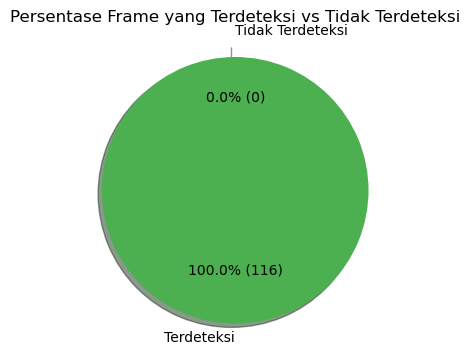

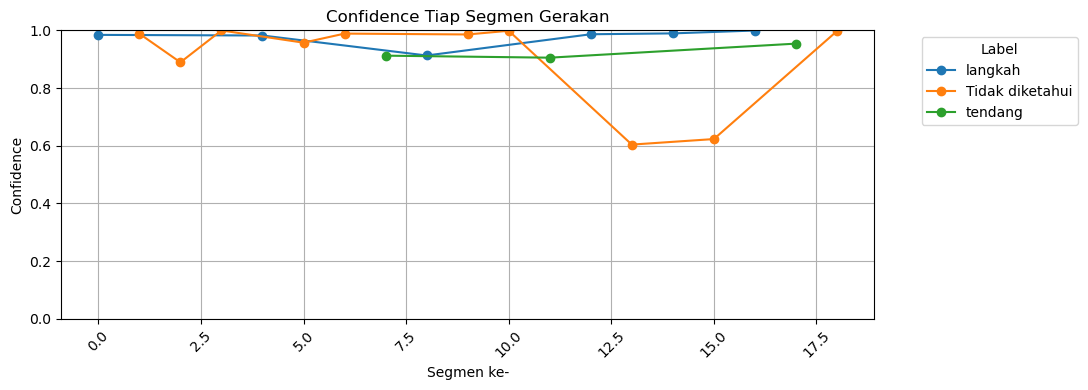

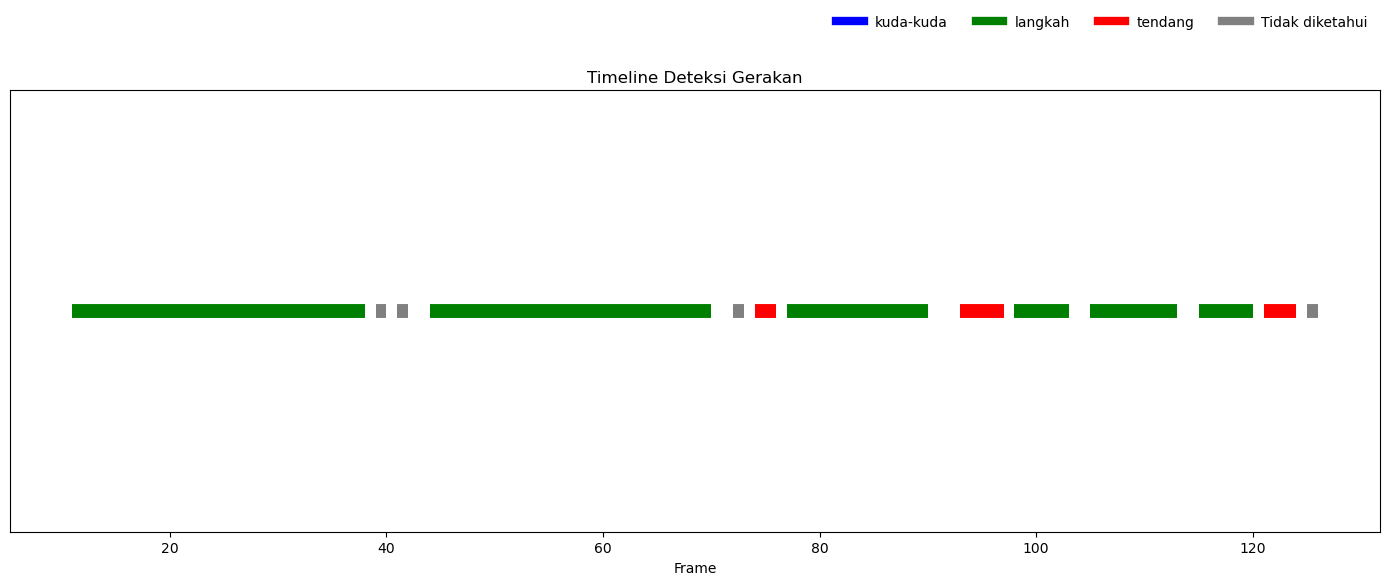

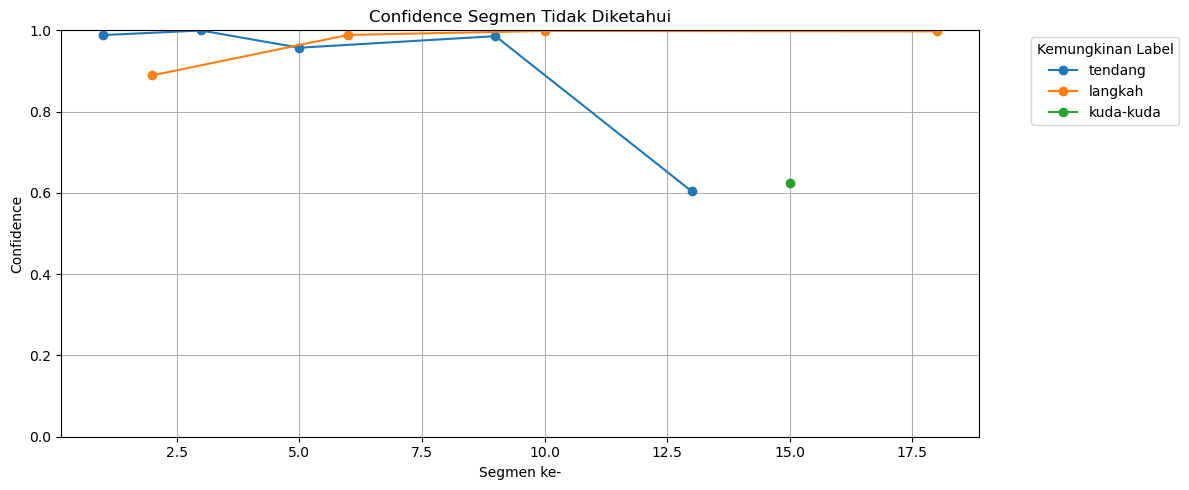


Total frame tidak dikategorikan: 14
Persentase frame tidak dikategorikan: 12.07%


In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow.keras.losses as losses
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# === PATH SETTING ===
MODEL_PREDIKSI_PATH = "C:/Users/user/model_terbaik_prediksi2.h5"
MODEL_KLASIFIKASI_PATH = "C:/Users/user/best_model7_2.h5"

CSV_PATH = "C:/Users/user/Downloads/demo_skripsi/keypoints_output (3).csv"

# === LABELS GERAKAN ===
index_to_label = {
    0: "langkah",
    1: "kuda-kuda",
    2: "tendang"
}

# === PARAMETER MODEL ===
SEQ_LENGTH = 10
CONFIDENCE_THRESHOLD = 0.5
MIN_ACTION_FRAMES = 3

# === PREPROCESSING ===
def preprocess_data(data: pd.DataFrame):
    print("=== Mengecek nilai hilang ===")
    print(data.isnull().sum())
    data_cleaned = data.dropna()
    keypoint_columns = [f'{axis}_{i}' for i in range(23, 33) for axis in ['x', 'y', 'z']]
    keypoints_data = data_cleaned[keypoint_columns]
    scaler = MinMaxScaler()
    keypoints_normalized = scaler.fit_transform(keypoints_data)
    return keypoints_normalized

# === KLASIFIKASI FRAME ===
def klasifikasikan_frame_full(frame, model_klasifikasi):
    input_shape = model_klasifikasi.input_shape
    _, seq_len, fitur = input_shape
    if frame.shape[0] != fitur:
        raise ValueError(f"Fitur frame ({frame.shape[0]}) tidak sesuai dengan input model ({fitur})")
    sequence = np.repeat(frame[np.newaxis, :], repeats=seq_len, axis=0)
    input_model = np.expand_dims(sequence, axis=0)
    pred = model_klasifikasi.predict(input_model, verbose=0)[0]
    label_index = np.argmax(pred)
    confidence = pred[label_index]
    if confidence < CONFIDENCE_THRESHOLD:
        return "Tidak diketahui", confidence, index_to_label[label_index]
    return index_to_label[label_index], confidence, None

# === VISUALISASI ===
def plot_visualisasi_tergabung(label_path, labels):
    label_counts = {}
    total_frames = 0
    tidak_terdeteksi_count = 0

    for label, confidence, possible_label in labels:
        total_frames += 1
        if confidence >= CONFIDENCE_THRESHOLD:
            label_counts[label] = label_counts.get(label, 0) + 1
        else:
            tidak_terdeteksi_count += 1

    # Bar plot
    # === PIE CHART: Persentase Terdeteksi vs Tidak ===
    terdeteksi_count = total_frames - tidak_terdeteksi_count
    pie_labels = ['Terdeteksi', 'Tidak Terdeteksi']
    sizes = [terdeteksi_count, tidak_terdeteksi_count]
    colors = ['#4CAF50', '#F44336']
    explode = (0.1, 0)

    plt.figure(figsize=(4, 4))
    plt.pie(sizes, explode=explode, labels=pie_labels, colors=colors,
            autopct=lambda p: f'{p:.1f}% ({int(p * total_frames / 100)})',
            shadow=True, startangle=90)
    plt.title("Persentase Frame yang Terdeteksi vs Tidak Terdeteksi")
    plt.axis('equal')
    plt.show()

    # === BACA CSV HASIL DETEKSI GERAKAN ===
    df = pd.read_csv(label_path)
    df["Confidence"] = pd.to_numeric(df["Confidence"], errors="coerce")

    # === LINE PLOT: Confidence Tiap Segmen Gerakan ===
    plt.figure(figsize=(11, 4))
    for label in df["Label"].unique():
        subset = df[df["Label"] == label]
        plt.plot(subset.index, subset["Confidence"], marker="o", label=label)
    plt.title("Confidence Tiap Segmen Gerakan")
    plt.xlabel("Segmen ke-")
    plt.ylabel("Confidence")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # === TIMELINE: Deteksi Gerakan ===
    plt.figure(figsize=(14, 6))
    color_map = {
        "kuda-kuda": "blue",
        "langkah": "green",
        "tendang": "red",
        "Tidak diketahui": "gray"
    }

    # Gambar garis per gerakan
    for _, row in df.iterrows():
        plt.plot([row['Frame_Start'], row['Frame_End']], [1, 1],
                 color=color_map.get(row['Label'], "black"), linewidth=10, solid_capstyle='butt')

    # Buat legenda manual
    legend_elements = [
        Line2D([0], [0], color="blue", lw=6, label="kuda-kuda"),
        Line2D([0], [0], color="green", lw=6, label="langkah"),
        Line2D([0], [0], color="red", lw=6, label="tendang"),
        Line2D([0], [0], color="gray", lw=6, label="Tidak diketahui")
    ]

    plt.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1, 1.2), ncol=4, frameon=False)
    plt.yticks([])
    plt.title("Timeline Deteksi Gerakan")
    plt.xlabel("Frame")
    plt.tight_layout()
    plt.show()

    # === LINE PLOT: Confidence Segmen Tidak Diketahui ===
    df_unknown = df[df["Label"] == "Tidak diketahui"]
    if not df_unknown.empty:
        plt.figure(figsize=(12, 5))
        for label in df_unknown["Kemungkinan Label"].unique():
            subset = df_unknown[df_unknown["Kemungkinan Label"] == label]
            plt.plot(subset.index, subset["Confidence"], marker="o", label=label)
        plt.title("Confidence Segmen Tidak Diketahui")
        plt.xlabel("Segmen ke-")
        plt.ylabel("Confidence")
        plt.ylim(0, 1)
        plt.grid(True)
        plt.legend(title="Kemungkinan Label", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("Tidak ada segmen dengan label 'Tidak diketahui'.")

    # === STATISTIK RINGKAS ===
    total_unknown_frames = (df_unknown["Frame_End"] - df_unknown["Frame_Start"] + 1).sum()
    total_frames_segment = (df["Frame_End"] - df["Frame_Start"] + 1).sum()
    print(f"\nTotal frame tidak dikategorikan: {total_unknown_frames}")
    if total_frames_segment > 0:
        persentase = (total_unknown_frames / total_frames_segment) * 100
        print(f"Persentase frame tidak dikategorikan: {persentase:.2f}%")

# === MAIN FUNCTION ===
def main():
    model_prediksi = load_model(MODEL_PREDIKSI_PATH, compile=False)
    model_klasifikasi = load_model(MODEL_KLASIFIKASI_PATH, compile=False)
    df = pd.read_csv(CSV_PATH)
    keypoints_normalized = preprocess_data(df)
    N = keypoints_normalized.shape[0]
    if N < SEQ_LENGTH:
        raise ValueError(f"Data terlalu sedikit untuk sequence length={SEQ_LENGTH}")

    hasil_prediksi = []
    for i in range(SEQ_LENGTH, N):
        current_sequence = keypoints_normalized[i - SEQ_LENGTH:i]
        input_model = np.expand_dims(current_sequence, axis=0)
        pred_frame = model_prediksi.predict(input_model, verbose=0)[0]
        hasil_prediksi.append(pred_frame)
    hasil_prediksi = np.array(hasil_prediksi)

    TRUE_FRAMES = keypoints_normalized[SEQ_LENGTH:]
    PRED_FRAMES = hasil_prediksi

    print("\n=== EVALUASI PER FRAME ===")
    loss_fn = losses.MeanSquaredError()
    per_frame_mae, per_frame_rmse, per_frame_loss = [], [], []
    for i in range(len(PRED_FRAMES)):
        true = TRUE_FRAMES[i]
        pred = PRED_FRAMES[i]
        mae = mean_absolute_error([true], [pred])
        rmse = math.sqrt(mean_squared_error([true], [pred]))
        loss = loss_fn([true], [pred]).numpy()
        per_frame_mae.append(mae)
        per_frame_rmse.append(rmse)
        per_frame_loss.append(loss)
        print(f"Frame {i+SEQ_LENGTH+1}: MAE={mae:.6f}, RMSE={rmse:.6f}, Loss={loss:.6f}")

    df_eval_per_frame = pd.DataFrame({
        "Frame": list(range(SEQ_LENGTH+1, N+1)),
        "MAE": per_frame_mae,
        "RMSE": per_frame_rmse,
        "Loss": per_frame_loss
    })
    df_eval_per_frame.to_csv("evaluasi_setiap_frame.csv", index=False)

    print("\n=== DETEKSI SEKUENSI GERAKAN ===")
    labels = []
    for frame in hasil_prediksi:
        label, confidence, possible_label = klasifikasikan_frame_full(frame, model_klasifikasi)
        labels.append((label, confidence, possible_label))

    grouped_actions = []
    current_label, _, current_possible = labels[0]
    current_confidences = [labels[0][1]]
    possible_labels = [labels[0][2]] if labels[0][2] else []
    start_frame = SEQ_LENGTH + 1

    for i in range(1, len(labels)):
        label, conf, poss_label = labels[i]
        if label == current_label:
            current_confidences.append(conf)
            if poss_label: possible_labels.append(poss_label)
        else:
            end_frame = SEQ_LENGTH + i
            avg_conf = np.mean(current_confidences)
            frame_count = end_frame - start_frame + 1
            kemungkinan_label = max(set(possible_labels), key=possible_labels.count) if possible_labels else current_label
            grouped_actions.append({
                "Label": current_label if frame_count >= MIN_ACTION_FRAMES else "Tidak diketahui",
                "Frame_Start": start_frame,
                "Frame_End": end_frame,
                "Confidence": avg_conf,
                "Kemungkinan Label": "-" if frame_count >= MIN_ACTION_FRAMES else kemungkinan_label
            })
            current_label = label
            current_confidences = [conf]
            possible_labels = [poss_label] if poss_label else []
            start_frame = SEQ_LENGTH + i + 1

    end_frame = SEQ_LENGTH + len(labels)
    avg_conf = np.mean(current_confidences)
    frame_count = end_frame - start_frame + 1
    kemungkinan_label = max(set(possible_labels), key=possible_labels.count) if possible_labels else current_label
    grouped_actions.append({
        "Label": current_label if frame_count >= MIN_ACTION_FRAMES else "Tidak diketahui",
        "Frame_Start": start_frame,
        "Frame_End": end_frame,
        "Confidence": avg_conf,
        "Kemungkinan Label": "-" if frame_count >= MIN_ACTION_FRAMES else kemungkinan_label
    })

    df_actions = pd.DataFrame(grouped_actions)
    df_actions.to_csv("deteksi_gerakan_urut.csv", index=False)

    print("\n=== HASIL DETEKSI GERAKAN ===")
    for action in grouped_actions:
        print(f"Gerakan: {action['Label']} (Frame {action['Frame_Start']} - {action['Frame_End']}), Confidence: {action['Confidence']:.2%}, Kemungkinan: {action['Kemungkinan Label']}")
    
                # === SIMPAN SEMUA DATA, TAMPILKAN 20 PERTAMA ===
    keypoint_columns = [f'{axis}_{i}' for i in range(23, 33) for axis in ['x', 'y', 'z']]

    df_true = pd.DataFrame(TRUE_FRAMES, columns=[f'True_{col}' for col in keypoint_columns])
    df_pred = pd.DataFrame(PRED_FRAMES, columns=[f'Pred_{col}' for col in keypoint_columns])

    df_compare = pd.concat([df_true, df_pred], axis=1)

    # Tampilkan hanya 20 baris pertama
    print("\n=== Perbandingan 20 baris pertama: Data Asli vs Prediksi ===")
    print(df_compare.head(20))

    # Simpan seluruh data ke CSV
    OUTPUT_CSV_PATH = "prediksi_keypoints_vs_asli.csv"
    df_compare.to_csv(OUTPUT_CSV_PATH, index=False)
    print(f"\nSeluruh hasil disimpan ke: {OUTPUT_CSV_PATH}")
    plot_visualisasi_tergabung("deteksi_gerakan_urut.csv", labels)

if __name__ == "__main__":
    main()
